In [2]:
import findspark
# findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
findspark.init('../spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('transformation').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/21 06:26:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data Transformation

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.sql.functions import col, when
df = spark.read.csv('cleaned.csv', header=True)
df.printSchema()

root
 |-- Diabetes: string (nullable = true)
 |-- HighBP: string (nullable = true)
 |-- HighChol: string (nullable = true)
 |-- CholCheck: string (nullable = true)
 |-- Smoker: string (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- HeartDiseaseorAttack: string (nullable = true)
 |-- PhysActivity: string (nullable = true)
 |-- Fruits: string (nullable = true)
 |-- Veggies: string (nullable = true)
 |-- HvyAlcoholConsump: string (nullable = true)
 |-- AnyHealthcare: string (nullable = true)
 |-- NoDocbcCost: string (nullable = true)
 |-- DiffWalk: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- GenHlth: string (nullable = true)
 |-- MentHlth: string (nullable = true)
 |-- PhysHlth: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Income: string (nullable = true)



### All columns are in type string. Needed to be double

In [4]:
cols = ['HighBP', 'HighChol', 'CholCheck',
       'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits',
       'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
       'DiffWalk', 'Sex', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age',
       'Education', 'Income']
df = df.withColumn('Diabetes',col('Diabetes').cast('double'))
for c in cols:
    df = df.withColumn(c,col(c).cast('double'))
    
df.printSchema()

root
 |-- Diabetes: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



### Feature selection using Chi-square selector

In [5]:
assembler = VectorAssembler(inputCols=cols, outputCol="features")
df = assembler.transform(df)

selector = ChiSqSelector(featuresCol="features", outputCol="selected_features", \
                         labelCol="Diabetes", numTopFeatures=15)
model = selector.fit(df)
df = model.transform(df)
selected_indices = model.selectedFeatures
selected_feature_names = [df.columns[index] for index in selected_indices]

In [6]:
print(selected_feature_names)

['Diabetes', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', 'BMI']


In [7]:
# df.show()

## Under sampling for imbalanced data

In [8]:
from pyspark.sql.functions import col, explode, array, lit
major_df = df.filter(col("Diabetes") == 0)
minor_df = df.filter(col("Diabetes") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 6


In [9]:
sampled_majority_df = major_df.sample(False, 1/ratio)
balanced_data = sampled_majority_df.unionAll(minor_df)
print(sampled_majority_df.count() / minor_df.count())

1.0284408182160114


## Distribution plots before and after under-sampling

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

24/05/21 06:26:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


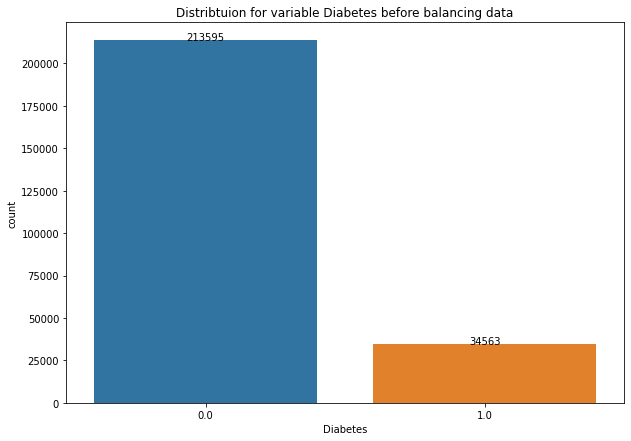

In [11]:
df_imbalanced = df.toPandas()
# Distribtuion for target variable Diabetes before balancing data
fig, ax1 = plt.subplots(figsize=(10,7))
graph = sns.countplot(ax=ax1,x='Diabetes', data=df_imbalanced)
graph.set_title("Distribtuion for variable Diabetes before balancing data")
graph.set_xticklabels(graph.get_xticklabels())
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
    df_imbalanced['Diabetes'].value_counts()[i],ha="center")
    i += 1

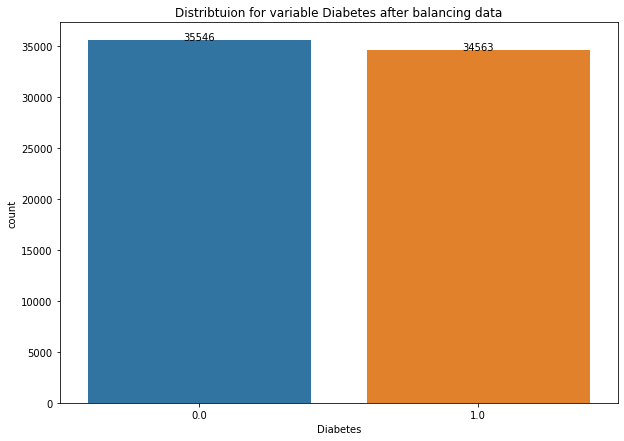

In [12]:
df_balanced = balanced_data.toPandas()
# Distribtuion for target variable Diabetes after balancing data
fig, ax1 = plt.subplots(figsize=(10,7))
graph = sns.countplot(ax=ax1,x='Diabetes', data=df_balanced)
graph.set_title("Distribtuion for variable Diabetes after balancing data")
graph.set_xticklabels(graph.get_xticklabels())
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
    df_balanced['Diabetes'].value_counts()[i],ha="center")
    i += 1

## Save selected balanced data

In [16]:
result_data = balanced_data.select(selected_feature_names)

In [18]:
result_data.printSchema()

root
 |-- Diabetes: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- BMI: double (nullable = true)



In [19]:
result_data.write.option("header", True).option("sep", ",").csv("data.csv")

In [ ]:
# train_df, test_df = df.randomSplit(weights=[0.7,0.3], seed=100)